# **Lab 3. Neural Architecture Search**

## 0. Setup

In [ ]:
# graphviz
!apt-get install graphviz 1>/dev/null

# mcunetv2 codebase
!mkdir -p /workspace/mcunetv2
!wget https://www.dropbox.com/s/3y2n2u3mfxczwcb/mcunetv2-dev-main.zip?dl=0 -O mcunetv2.zip >/dev/null
!unzip -q mcunetv2.zip -d /workspace/mcunetv2
!mv /workspace/mcunetv2/mcunetv2-dev-main/* /workspace/mcunetv2/
!rm mcunetv2.zip

# vww dataset
!mkdir -p /workspace/data/vww
!wget https://www.dropbox.com/s/169okcuuv64d4nn/data.zip?dl=0 -O data.zip >/dev/null
!unzip -q data.zip -d /workspace/data/vww
!rm data.zip

# thop & onnx
%pip install thop 1>/dev/null
%pip install onnx 1>/dev/null
%pip install graphviz 1>/dev/null

In [1]:
import os
import sys
import json
import copy
import math
import torch
import random
import warnings
import argparse
import numpy as np
import torch.nn as nn
import torchvision.transforms as T

%matplotlib inline
warnings.filterwarnings('ignore')
sys.path.append('/workspace/mcunetv2')

from PIL import Image
from tqdm import tqdm
from torchvision import datasets
from matplotlib import pyplot as plt
from mcunet.tinynas.search.accuracy_predictor import AccuracyDataset, MCUNetArchEncoder
from mcunet.tinynas.elastic_nn.networks.ofa_mcunets import OFAMCUNets
from mcunet.utils.mcunet_eval_helper import calib_bn, validate
from mcunet.utils.arch_visualization_helper import draw_arch
from mcunet.utils.pytorch_utils import count_peak_activation_size, count_net_flops, count_parameters

## 1. Super Network & VWW dataset

In this lab, we will be using the **[MCUNetV2](https://arxiv.org/abs/2110.15352)** *super network* trained in an **once-for-all (OFA)** manner. Recall that *super network* is a randomized large neural network that contains all candidate subnets within the design space. We can directly extract the subnets from the super network and evaluate their accuracy. The accuracy can be further used as a feedback signal to guide neural network design. The advantage of OFA super network is that the directly extracted subnets can achieve similar (or even better) performance compared with training from scratch.

MCUNetV2 is a family of efficiency neural networks tailored for resource-constrained microntrollers. It utilizes patch-based inference, receptive field redistribution and system-NN co-design and greatly improves the accuracy-efficiency tradeoff of [MCUNet](https://arxiv.org/abs/2007.10319).

### Build VWW DataLoader

VWW Dataset is a binary image classficiation (whether people is present in the image) dataset subsampled from [Microsoft COCO](https://arxiv.org/abs/1405.0312).

In [2]:
def build_val_data_loader(data_dir, resolution, batch_size=128, split=0):
    # split 0: val set, split 1: test set
    assert split in [0, 1]
    
    # configuration
    mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
    kwargs = {"num_workers": min(8, os.cpu_count()), "pin_memory": False}

    # transform function
    val_transform = T.Compose([
        # if center crop, object might be excluded
        T.Resize((resolution, resolution)),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

    # build loader
    val_dataset = datasets.ImageFolder(data_dir, transform=val_transform)
    val_dataset = torch.utils.data.Subset(
        val_dataset, list(range(len(val_dataset)))[split::2]
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, **kwargs
    )

    return val_loader

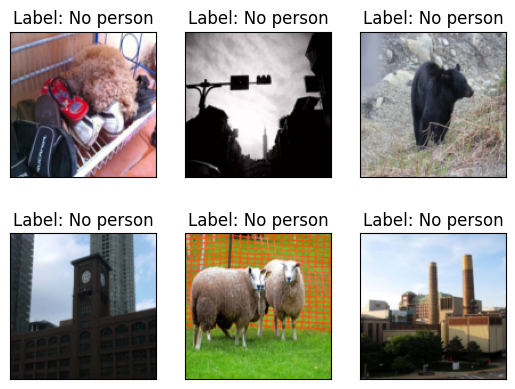

In [3]:
# build data loader
data_dir = "/workspace/data/vww/data/vww-s256/val"
val_data_loader = build_val_data_loader(data_dir, resolution=128, batch_size=1)

# visualize
x, y = 2, 3
fig, axs = plt.subplots(x, y)

num_imgs = 0
for data, label in val_data_loader:
    img = np.array((((data + 1) / 2) * 255).numpy(), dtype=np.uint8)
    img = img[0].transpose(1, 2, 0)

    if label.item() == 0: label_text = "No person"
    else: label_text = "Person"

    axs[num_imgs // y][num_imgs % y].imshow(img)
    axs[num_imgs // y][num_imgs % y].set_title(f"Label: {label_text}")
    axs[num_imgs // y][num_imgs % y].set_xticks([])
    axs[num_imgs // y][num_imgs % y].set_yticks([])

    num_imgs += 1
    if num_imgs > x * y - 1: break

plt.show()

### Construct OFA Super Network

The `OFAMCUNets` super network is composed of $>10^{19}$ subnets in the MCUNetV2 design space. The subnets are composed of [inverted MobileNet blocks](https://arxiv.org/abs/1801.04381) with different kernel sizes (3, 5, 7) and expand ratios (3, 4, 6). The OFA super network also allows elastic depths (base depth to base_depth + 2) for all network stages. Finally, the super network supports global channel scaling (specified by `width_mult_list`) by 0.5x, 0.75x or 1.0x.

In [4]:
# set the device
device = "cuda:0"

# initialize the network
ofa_network = OFAMCUNets(
    n_classes=2,
    bn_param=(0.1, 1e-3),               # gamma, beta
    dropout_rate=0.0,
    base_stage_width="mcunet384",
    width_mult_list=[0.5, 0.75, 1.0],   # channel scaling
    ks_list=[3, 5, 7],                  # elastic kernels
    expand_ratio_list=[3, 4, 6],        # expansion ratios (inverted residual block)
    depth_list=[0, 1, 2],               # elastic depths
    base_depth=[1, 2, 2, 2, 2],         # depth = base_depth + elastic depth
    fuse_blk1=True,
    se_stages=[False, [False, True, True, True], True, True, True, False]
)

# load the pre-trained weight
ofa_network.load_state_dict(
    torch.load("/workspace/mcunetv2/vww_supernet.pth", map_location="cpu")["state_dict"], strict=True
)

# move to gpu
ofa_network = ofa_network.to(device)

### Evaluate Sub-network on the VWW Dataset

We will sample some networks in the MCUNetV2 design space and evaluate its accuracy on the VWW dataset. The evaluation will take less than one minutes, and you are expected to see an accuracy around 83.6-88.7%. As you can see, we can directly extract these subnets from the design space and get their accuracy very quickly without training. This is a unique advantage brought by once-for-all (OFA) super networks.

In [5]:
def evaluate_sub_network(ofa_network, cfg, img_size=None):
    # configration
    batch_size = 128
    if "image_size" in cfg:
        img_size = cfg["image_size"]

    # sample the active subnet
    ofa_network.set_active_subnet(**cfg)

    # extract the subnet
    subnet = ofa_network.get_active_subnet().to(device)

    # calculate the efficiency stats
    peak_memory = count_peak_activation_size(subnet, (1, 3, img_size, img_size))
    macs = count_net_flops(subnet, (1, 3, img_size, img_size))
    params = count_parameters(subnet)
    
    # perform BN parameter re-calibration
    calib_bn(subnet, data_dir, batch_size, img_size)

    # define the validation loader
    val_loader = build_val_data_loader(data_dir, img_size, batch_size)

    # validate the accuracy
    acc = validate(subnet, val_loader)

    return acc, peak_memory, macs, params

In [6]:
def visualize_subnet(cfg):
    # draw architecture
    draw_arch(cfg["ks"], cfg["e"], cfg["d"], cfg["image_size"], out_name="viz/subnet")

    # process the image
    im = Image.open("viz/subnet.png")
    im = im.rotate(90, expand=1)
    
    # visualize
    fig = plt.figure(figsize=(im.size[0] / 250, im.size[1] / 250))
    plt.axis("off")
    
    plt.imshow(im)
    plt.show()

Validate: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s, loss=0.292, top1=87.7]


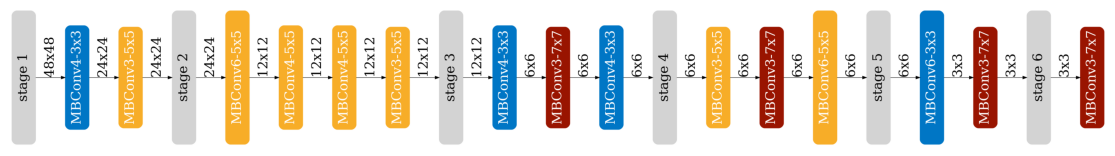

The accuracy of the sampled subnet: #params= 0.9M, accuracy= 87.7%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 20.39it/s, loss=0.29, top1=88.6] 


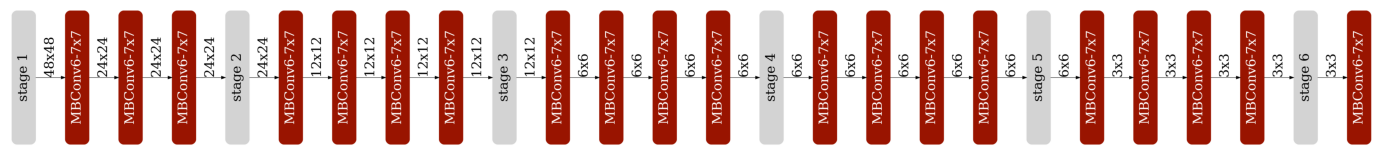

The largest subnet: #params= 2.5M, accuracy= 88.6%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 26.78it/s, loss=0.379, top1=83.4]


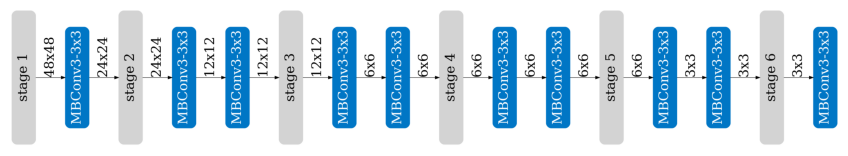

The smallest subnet: #params= 0.3M, accuracy= 83.4%.


In [7]:
img_size = 96

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=img_size)
acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
visualize_subnet(cfg)
print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=img_size)
acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
visualize_subnet(largest_cfg)
print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=img_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
visualize_subnet(smallest_cfg)
print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

#### Question 1

Try manually sample different subnets by running the cell above multiple times. You can also vary the input resolution. Talk about your findings.

**Hint**

which dimension plays the most important role for the accuracy?

*EXP 1. 각 elastic dimension 별 정확도 차이 비교*

In [9]:
def create_configs(base_cfg):
    cfgs = {}

    # kernel size 최대
    cfgs['max_kernel'] = base_cfg.copy()
    cfgs['max_kernel']['ks'] = [7] * 5

    # expansion ratio 최대
    cfgs['max_expansion'] = base_cfg.copy()
    cfgs['max_expansion']['e'] = [6] * 5

    # depth 최대
    cfgs['max_depth'] = base_cfg.copy()
    cfgs['max_depth']['d'] = [2] * 5

    # width multiplier 최대
    cfgs['max_width'] = base_cfg.copy()
    cfgs['max_width']['width_mult'] = 1.0

    return cfgs

In [10]:
img_size = 96

# baseline
base_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=img_size)
acc, _, _, params = evaluate_sub_network(ofa_network, base_cfg)
print(f"The accuracy of the baseline subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

# create configs
cfgs = create_configs(base_cfg)

# compare accuracy of elastic dimensions
for cfg_name, cfg in cfgs.items():
    acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
    print(f"The accuracy of the {cfg_name} subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

Validate: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s, loss=0.379, top1=83.4]


The accuracy of the baseline subnet: #params= 0.3M, accuracy= 83.4%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 26.02it/s, loss=0.365, top1=84.2]


The accuracy of the max_kernel subnet: #params= 0.3M, accuracy= 84.2%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 27.04it/s, loss=0.353, top1=84.5]


The accuracy of the max_expansion subnet: #params= 0.3M, accuracy= 84.5%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 24.95it/s, loss=0.339, top1=85.7]


The accuracy of the max_depth subnet: #params= 0.5M, accuracy= 85.7%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 27.07it/s, loss=0.379, top1=83.4]

The accuracy of the max_width subnet: #params= 0.3M, accuracy= 83.4%.


*EXP 2. Resolution 에 따른 정확도 차이*

In [11]:
img_size_list = [96, 128, 256, 512]
for img_size in img_size_list:
    base_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=img_size)
    acc, _, _, params = evaluate_sub_network(ofa_network, base_cfg)
    print(f"The accuracy of the {img_size} subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

Validate: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s, loss=0.379, top1=83.4]


The accuracy of the 96 subnet: #params= 0.3M, accuracy= 83.4%.


Validate: 100%|██████████| 32/32 [00:01<00:00, 22.22it/s, loss=0.307, top1=87.3]


The accuracy of the 128 subnet: #params= 0.3M, accuracy= 87.3%.


Validate: 100%|██████████| 32/32 [00:02<00:00, 12.46it/s, loss=0.258, top1=90.3]


The accuracy of the 256 subnet: #params= 0.3M, accuracy= 90.3%.


Validate: 100%|██████████| 32/32 [00:09<00:00,  3.28it/s, loss=0.489, top1=76.1]


The accuracy of the 512 subnet: #params= 0.3M, accuracy= 76.1%.


**Answer**

* EXP1
    
    실험 1을 통해서 동일한 이미지 해상도 상에서는 depth가 모델의 정확도에 가장 큰 영향을 준다는 사실을 알 수 있습니다.

* EXP2

    실험 2에서는 **이미지의 해상도**가 모델의 정확도에 가장 큰 영향을 주지만 512px 부터는 오히려 정확도가 떨어지는 현상을 확인할 수 있습니다.
    
    > 원인 1. 원본 이미지의 해상도가 대부분 (400, 300)을 넘지 않기 때문에 이를 강제로 ```Resize```하는 과정에서 정보 손실 \
    > 원인 2. 0.3M 의 모델 크기로는 (512, 512) 의 이미지 해상도에 대한 표현력 부족


## 2. Predictors

Neural architecture search requires sampling a large amount of sub-networks from the OFA supernet and evaluate the performance of these sub-networks. Such performance evaluation is time-consuming.

In this lab, we explore very fast neural network search with **efficiency predictors** and **accuracy predictors**. 

### Efficiency Predictor

For the efficiency predictor, we use an hook-based analytical model to count the #MACs and peak memory consumption of a given network. Let's build it from scratch using our provided APIs.

#### Question 2

Specifically, we define a class called `AnalyticalEfficiencyPredictor`. There are two major functions in this class, `get_efficiency` and `satisfy_constraint`.

The function `get_efficiency` takes in the subnet configuration and returns the #MACs and peak memory of the given subnet. Here, we assume the unit for the #MACs is million and the unit of the peak memory consumption is KB.

**Hint**

take a look at the `evaluate_sub_network` function above. Let's use `count_net_flops` to get the MACs of the network and `count_peak_activation_size` to get the activation size of the network.

In [7]:
class AnalyticalEfficiencyPredictor:
    def __init__(self, net):
        self.net = net

    def get_efficiency(self, spec: dict):
        self.net.set_active_subnet(**spec)
        
        subnet = self.net.get_active_subnet()
        if torch.cuda.is_available():
            subnet = subnet.cuda()

        data_shape = (1, 3, spec['image_size'], spec['image_size'])
        macs = count_net_flops(subnet, data_shape)
        peak_memory = count_peak_activation_size(subnet, data_shape)

        return dict(millionMACs=macs / 1e6, KBPeakMemory=peak_memory / 1024)

    def satisfy_constraint(self, measured: dict, target: dict):
        for key in measured:
            # constraint is not specified
            if key not in target: continue

            # exceed the constraint
            if measured[key] > target[key]: return False

        # satisfy the constraint
        return True

In [8]:
efficiency_predictor = AnalyticalEfficiencyPredictor(ofa_network)
img_size = 96

# smallest subnet
smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=img_size)
eff_smallest = efficiency_predictor.get_efficiency(smallest_cfg)

# largest subnet
largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=img_size)
eff_largest = efficiency_predictor.get_efficiency(largest_cfg)

print("Efficiency stats of the smallest subnet:", eff_smallest)
print("Efficiency stats of the largest subnet:", eff_largest)

Efficiency stats of the smallest subnet: {'millionMACs': 8.302128, 'KBPeakMemory': 72.0}
Efficiency stats of the largest subnet: {'millionMACs': 79.416432, 'KBPeakMemory': 270.0}


### Accuracy Predictor

For the accuracy predictor, it predicts the classification accuracy of a given sub-network on the VWW dataset so that we do **NOT** need to run costly inference every time when we encounter a new subnet during architecture search. Such an accuracy predictor is an MLP (multi-layer perception) model trained on an accuracy dataset built with the OFA network. The inference of an MLP network takes only a few milliseconds, thus the accuracy predictor can speedup the search process by **orders of magnitude**.

#### Question 3

The accuracy predictor takes in the architecture of a sub-network and predicts its accuracy on the VWW dataset. Since it is an MLP network, the sub-network must be encoded into a vector. In this lab, we provide a class MCUNetArchEncoder to perform such conversion from sub-network architecture to a binary vector.

In [9]:
img_size_list = [96, 112, 128, 144, 160]
arch_encoder = MCUNetArchEncoder(
    image_size_list=img_size_list,
    base_depth=ofa_network.base_depth,
    depth_list=ofa_network.depth_list,
    expand_list=ofa_network.expand_ratio_list,
    width_mult_list=ofa_network.width_mult_list
)

In [10]:
class AccuracyPredictor(nn.Module):
    def __init__(
        self,
        arch_encoder,
        hidden_size=400,
        n_layers=3,
        ckpt_path=None,
        device="cuda:0"
    ):
        super(AccuracyPredictor, self).__init__()
        self.arch_encoder = arch_encoder
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = device

        layers = []

        # MLP for predictor
        for i in range(self.n_layers):
            in_dim = self.arch_encoder.n_dim if i == 0 else self.hidden_size
            layers.append(
                nn.Sequential(
                    nn.Linear(in_dim, hidden_size),
                    nn.ReLU(hidden_size)
                )
            )
        
        # output layer for regression
        layers.append(
            nn.Linear(self.hidden_size, 1, bias=False)
        )

        self.layers = nn.Sequential(*layers)
        self.base_acc = nn.Parameter(torch.zeros(1, device=self.device), requires_grad=True)

        # load the checkpoint weights
        if ckpt_path is not None and os.path.exists(ckpt_path):
            ckpt = torch.load(ckpt_path, map_location="cpu")
            if "state_dict" in ckpt:
                ckpt = ckpt['state_dict']
            self.load_state_dict(ckpt)
        
        self.layers.to(self.device)
    
    def forward(self, x):
        # base accuracy와의 상대적인 정확도 변화를 학습
        y = self.layers(x).squeeze()
        return y + self.base_acc

    def predict_acc(self, arch_dict_list):
        X = [
            self.arch_encoder.arch2feature(arch_dict)
            for arch_dict in arch_dict_list
        ]
        X = torch.tensor(np.array(X)).float().to(self.device)
        return self.forward(X)

In [11]:
acc_predictor = AccuracyPredictor(
    arch_encoder,
    hidden_size=400,
    n_layers=3,
    ckpt_path=None,
    device=device,
)

print(acc_predictor)

AccuracyPredictor(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (3): Linear(in_features=400, out_features=1, bias=False)
  )
)


### Train the Accuracy Predictor

The accuracy dataset is composed of 50,000 `[architecture, accuracy]` pairs, where 40,000 of them are used as the training set and the rest 10,000 are used as validation set.

For **accuracy**, We calculate the average accuracy of all `[architecture, accuracy]` pairs on the accuracy dataset and define it as `base_acc`. For the accuracy predictor, instead of directly regressing the accuracy of each architecture, its training target is `accuracy - base_acc`. Since `accuracy - base_acc` is usually much smaller than `accuracy` itself, this can make training easier.

For **architecture**, each subnet within the design space is uniquely represented by a binary vector. The binary vector is a concatenation of the **one-hot representation** for both global parameters (*e.g.* input resolution, width multiplier) and parameters of each inverted MobileNet block (*e.g.* kernel sizes and expand ratios). Note that we prefer **one-hot** representations over **numerical** representations because all design hyperparameters are **discrete** values.

For example, our design space supports

```python
kernel_size = [3, 5, 7]
expand_ratio = [3, 4, 6]
```

Then, we represent `kernel_size=3` as `[1, 0, 0]`, `kernel_size=5` as `[0, 1, 0]`, and `kernel_size=7` as `[0, 0, 1]`. Similarly, for `expand_ratio=3`, it is written as `[1, 0, 0]`; `expand_ratio=4` is written as `[0, 1, 0]` and `expand_ratio=6` is written as `[0, 0, 1]`. The representation for each inverted MobileNet block is obtained by concatenating the kernel size embedding with the expand ratio embedding. Note that for skipped blocks, we use `[0, 0, 0]` to represent their kernel sizes and expand ratios. You will see a detailed explanation of the architecture-embedding correspondence after running the following cell.

Loading data: 100%|██████████| 50000/50000 [00:00<00:00, 142249.04it/s]


Train Size: 40000, Valid Size: 10000
baseline accuracy (mean accuracy of all subnets within the dataset):  90.3%.
network embedding: [0 0 0 0 1 | 0 1 0 | 1 0 0 | 0 1 0 | 1 0 0 | 1 0 0 | 1 0 0 | 0 1 0 | 0 0 1 | 0 1 0 | 1 0 0 | 1 0 0 | 0 0 1 | 0 0 1 | 0 0 0 | 0 0 0 | 1 0 0 | 1 0 0 | 1 0 0 | 1 0 0 | 0 0 1 | 0 1 0 | 0 0 1 | 0 1 0 | 1 0 0 | 1 0 0 | 1 0 0 | 0 0 1 | 0 1 0 | 0 1 0 | 1 0 0 | 0 1 0 | 1 0 0 | 0 0 1 | 0 1 0 | 0 0 1 | 0 0 0 | 0 0 0 | 0 0 0 | 0 0 0 | 0 1 0 | 0 1 0]
image resolution embedding: [0 0 0 0 1] => image resolution: 160
width multiplier embedding: [0 1 0] => width multiplier: 0.75
**************************************************Stage1**************************************************
kernel size embedding: [1 0 0] => kernel size: 3; expand ratio embedding: [0 1 0] => expand ratio: 4
kernel size embedding: [1 0 0] => kernel size: 3; expand ratio embedding: [1 0 0] => expand ratio: 3
kernel size embedding: [1 0 0] => kernel size: 3; expand ratio embedding: [0 1 0] => expand

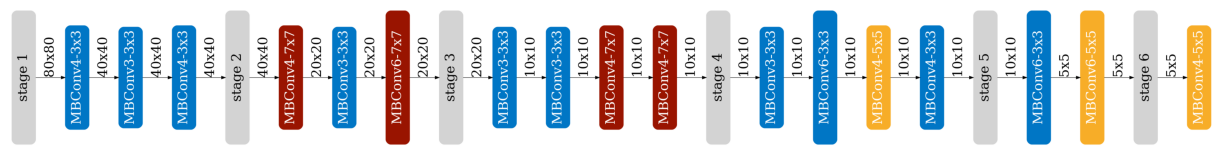

accuracy of this subnet on the test set:  92.9%.


In [12]:
acc_dataset = AccuracyDataset("/workspace/mcunetv2/acc_datasets")
train_loader, val_loader, base_acc = acc_dataset.build_acc_data_loader(arch_encoder=arch_encoder)

# baseline accuracy
print(f"baseline accuracy (mean accuracy of all subnets within the dataset): {(base_acc * 100): .1f}%.")

# a sample in the training set
for (data, label) in train_loader:
    # move cpu to gpu
    data = data.to(device)
    label = label.to(device)

    # dummy pass
    print("=" * 100)
    arch_encoding = arch_encoder.feature2arch(data[0].int().cpu().numpy(), verbose=False)
    arch_encoding = arch_encoder.feature2arch(data[0].int().cpu().numpy(), verbose=True)

    # visualize & subnet accuracy
    visualize_subnet(arch_encoding)
    print(f"accuracy of this subnet on the test set: {(label[0] * 100): .1f}%.")
    
    break

#### Question 4

Let's train the accuracy predictor using the dataset we provided! In this part, you are responsible for the implementation of the training and validation of your accuracy predictor. The training process will take roughly 1-2 minutes.

**Hint**

you may refer to Tutorial 2 on how to train a neural network with PyTorch.

In [13]:
# checkpoint path
acc_pred_ckpt_path = f"/workspace/model/{ofa_network.__class__.__name__}.acc_predictor.pth"

# loss function & optimizer
criterion = torch.nn.L1Loss().to(device)
optimizer = torch.optim.Adam(acc_predictor.parameters())

# update the baseline accuracy
acc_predictor.base_acc.data += base_acc

In [20]:
EPOCHS = 10
for epoch in tqdm(range(EPOCHS)):
    # train
    acc_predictor.train()
    
    for (data, label) in tqdm(train_loader, desc="Epoch%d" % (epoch + 1), position=0, leave=True):
        # move cpu to gpu
        data = data.to(device)
        label = label.to(device)

        # reset the gradients
        optimizer.zero_grad()

        # forward inference
        pred = acc_predictor(data)
        loss = criterion(pred, label)

        # backward propagation
        loss.backward()
        optimizer.step()

    # validation
    acc_predictor.eval()
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Val', position=0, leave=True) as t:
            for (data, label) in val_loader:
                # move cpu to gpu
                data = data.to(device)
                label = label.to(device)

                # forward inference
                pred = acc_predictor(data)
                loss = criterion(pred, label)  

                t.set_postfix({"loss": loss.item()})
                t.update(1)

# save checkpoint
if not os.path.exists(acc_pred_ckpt_path):
    torch.save(acc_predictor.cpu().state_dict(), acc_pred_ckpt_path)

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Val:   0%|          | 0/40 [00:00<?, ?it/s]


Text(0.5, 1.0, 'Correlation between predicted and ground-truth accuracy')

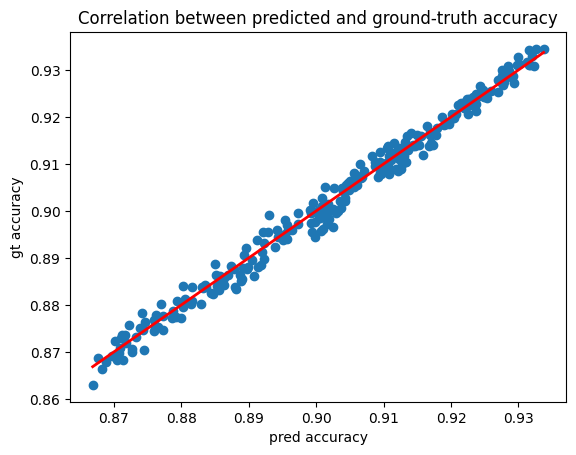

In [21]:
pred_accs, gt_accs = [], []
acc_predictor = acc_predictor.to(device)

# get accuracies
acc_predictor.eval()
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Val") as t:
        for (data, label) in val_loader:
            data = data.to(device)
            label = label.to(device)

            pred = acc_predictor(data)
            
            pred_accs += pred.cpu().numpy().tolist()
            gt_accs += label.cpu().numpy().tolist()

            if len(pred_accs) > 200: break

# visualize the correlation between pred and gt
plt.scatter(pred_accs, gt_accs)

min_acc, max_acc = min(pred_accs), max(pred_accs)
plt.plot([min_acc, max_acc], [min_acc, max_acc], c='red', linewidth=2)

plt.xlabel("pred accuracy")
plt.ylabel('gt accuracy')
plt.title('Correlation between predicted and ground-truth accuracy')

## 3. Neural Architecture Search

In this part, you are required to implement two typical search algorithms: **random search** and **evolutionary search**. The search algorithm aims to find the model architecture that provides the best accuracy while satisfying the efficiency constraints (e.g., MACs, peak memory).

### Random Search Agent

Random search works by repeatedly sampling models randomly within the search space to find the network with the best accuracy. It's generally used as an initial step to run a sanity check on the search space and the reward function (like an accuracy predictor), before proceeding with NAS using more advanced search strategies.

#### Question 5

Complete the following random search agent.

In [14]:
class RandomSearcher:
    def __init__(self, efficiency_predictor, accuracy_predictor):
        self.efficiency_predictor = efficiency_predictor
        self.accuracy_predictor = accuracy_predictor

    def random_valid_sample(self, constraint):
        while True:
            # randomly sample subnets
            sample = self.accuracy_predictor.arch_encoder.random_sample_arch()
            efficiency = self.efficiency_predictor.get_efficiency(sample)

            # return when subnet satisfies the constraint
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return sample, efficiency
    
    def run_search(self, constraint, n_subnets=100):
        subnet_pool = []

        # sample subnets
        for _ in tqdm(range(n_subnets)):
            sample, _ = self.random_valid_sample(constraint)
            subnet_pool.append(sample)

        # predict the accuracy
        accs = self.accuracy_predictor.predict_acc(subnet_pool)

        # get the index of the best subnet
        best_idx = accs.argmax()
        
        # return the best subnet
        return accs[best_idx], subnet_pool[best_idx]

#### Question 6

Complete the following function.

In [15]:
def search_and_measure_accs(agent, constraint, **kwargs):
    # search the best configuration
    best_info = agent.run_search(constraint, **kwargs)

    # get searched network
    ofa_network.set_active_subnet(**best_info[1])
    subnet = ofa_network.get_active_subnet().to(device)

    # calibrate bn
    calib_bn(subnet, data_dir, batch_size=128, resolution=best_info[1]["image_size"])

    # build validation loader
    val_loader = build_val_data_loader(data_dir, best_info[1]["image_size"])

    # measure accuracy
    acc = validate(subnet, val_loader)

    # visualize
    print(f"Accuracy of the selected subnet: {acc}")
    visualize_subnet(best_info[1])

    return acc, subnet

Random search with constraint: MACs <= 50M


  0%|          | 0/300 [00:00<?, ?it/s]

Validate: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s, loss=0.214, top1=92.4]


Accuracy of the selected subnet: 92.38213402532762


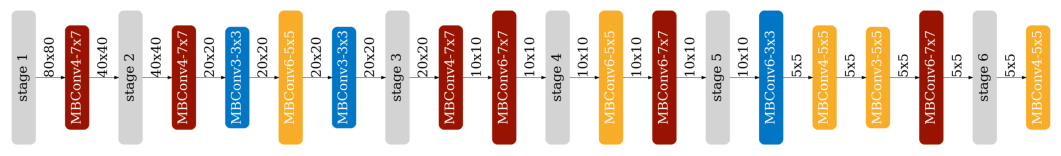

Random search with constraint: MACs <= 100M


Validate: 100%|██████████| 32/32 [00:01<00:00, 16.02it/s, loss=0.206, top1=92.8]


Accuracy of the selected subnet: 92.7543424620522


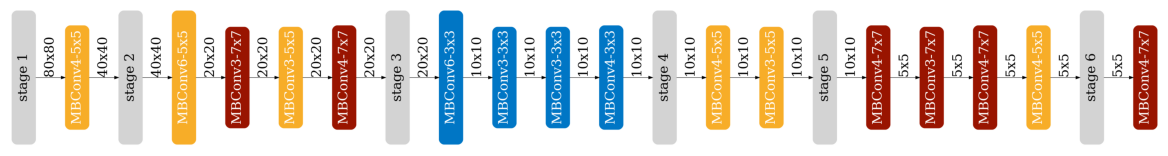

Random search with constraint: Peak memory <= 256KB


Validate: 100%|██████████| 32/32 [00:02<00:00, 15.86it/s, loss=0.213, top1=92.3]


Accuracy of the selected subnet: 92.25806448205233


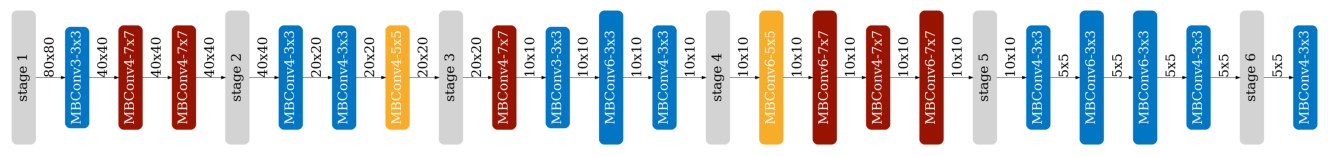

Random search with constraint: Peak memory <= 512KB


Validate: 100%|██████████| 32/32 [00:02<00:00, 13.11it/s, loss=0.195, top1=92.9]


Accuracy of the selected subnet: 92.90322583674201


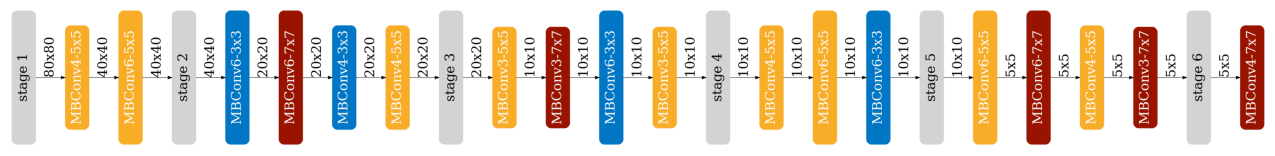

In [28]:
random.seed(1)
np.random.seed(1)

acc_predictor = AccuracyPredictor(
    arch_encoder,
    hidden_size=400,
    n_layers=3,
    ckpt_path=acc_pred_ckpt_path,
    device=device,
)
nas_agent = RandomSearcher(efficiency_predictor, acc_predictor)

# MACs-constrained search
subnets_rs_macs = {}
for millionMACs in [50, 100]:
    search_constraint = dict(millionMACs=millionMACs)
    print(f"Random search with constraint: MACs <= {millionMACs}M")
    subnets_rs_macs[millionMACs] = search_and_measure_accs(nas_agent, search_constraint, n_subnets=300)

# memory-constrained search
subnets_rs_memory = {}
for KBPeakMemory in [256, 512]:
    search_constraint = dict(KBPeakMemory=KBPeakMemory)
    print(f"Random search with constraint: Peak memory <= {KBPeakMemory}KB")
    subnets_rs_memory[KBPeakMemory] = search_and_measure_accs(nas_agent, search_constraint, n_subnets=300)

### Evolutionary Search Agent

In this part, we will implement a more sample-efficient search algorithm, evolutionary search. Evolutionary search is inspired by the evolution algorithm (or genetic algorithm).

A **population** of sub-networks are first sampled from the design space. Then, in each **generation**, we perform random mutation and crossover operations. The sub-networks with highest accuracy will be kept, and this process will be repeated until the number of generations reaches `max_time_budget`. Similar to the random search, throughout the search process, all sub-networks that cannot satisfy the efficiency constraint will be discarded.

- ```population``` \
    한 세대(generation)에서 평가할 subnet 개수 (탐색의 너비를 결정)

- ```max_time_budget```\
    진화(탐색)를 반복할 총 세대 수 (탐색의 깊이를 결정)

- ```parent_ratio``` \
    각 세대에서 생존시킬 subnet 비율 (top-K)

- ```mutation_ratio```\
    cross-over가 아닌 mutation으로 만들 subnet 비율 (crossover_ratio = 1 - mutation_ratio)

- ```arch_mutate_prob``` & ```resolution_mutate_prob```\
    mutation 단계에서 해상도와 아키텍처를 변경시킬 확률

In [40]:
random.seed(1)
np.random.seed(1)

#### Question 7

Complete the following evolutionary search agent.

In [16]:
class EvolutionSearcher:
    def __init__(self, efficiency_predictor, accuracy_predictor, **kwargs):
        self.efficiency_predictor = efficiency_predictor
        self.accuracy_predictor = accuracy_predictor

        # evloution hyper-parameter
        self.arch_mutate_prob = kwargs.get("arch_mutate_prob", 0.1)
        self.resolution_mutate_prob = kwargs.get("resolution_mutate_prob", 0.5)
        self.population_size = kwargs.get("population_size", 100)
        self.max_time_budget = kwargs.get("max_time_budget", 500)
        self.parent_ratio = kwargs.get("parent_ratio", 0.25)
        self.mutation_ratio = kwargs.get("mutation_ratio", 0.5)
    
    def update_hyper_params(self, new_param_dict):
        self.__dict__.update(new_param_dict)
    
    def random_valid_sample(self, constraint):
        while True:
            # randomly sample subnets
            sample = self.accuracy_predictor.arch_encoder.random_sample_arch()
            efficiency = self.efficiency_predictor.get_efficiency(sample)

            # return when subnet satisfies the constraint
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return sample, efficiency
    
    def mutate_sample(self, sample, constraint):
        while True:
            new_sample = copy.deepcopy(sample)

            # run mutation
            self.accuracy_predictor.arch_encoder.mutate_resolution(new_sample, self.resolution_mutate_prob)
            self.accuracy_predictor.arch_encoder.mutate_width(new_sample, self.arch_mutate_prob)
            self.accuracy_predictor.arch_encoder.mutate_arch(new_sample, self.arch_mutate_prob)

            # return when subnet satisfies the constraint
            efficiency = self.efficiency_predictor.get_efficiency(new_sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return new_sample, efficiency

    def crossover_sample(self, sample1, sample2, constraint):
        while True:
            new_sample = copy.deepcopy(sample1)

            # Randomly mix dimensions from sample1 and sample2.
            for key in new_sample.keys():
                if not isinstance(new_sample[key], list):
                    new_sample[key] = random.choice([sample1[key], sample2[key]])
                else:
                    for i in range(len(new_sample[key])):
                        new_sample[key][i] = random.choice([sample1[key][i], sample2[key][i]])

            # return when subnet satisfies the constraint
            efficiency = self.efficiency_predictor.get_efficiency(new_sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return new_sample, efficiency
        
    def run_search(self, constraint, **kwargs):
        self.update_hyper_params(kwargs)

        n_mutations = int(round(self.mutation_ratio * self.population_size))
        n_parents = int(round(self.parent_ratio * self.population_size))

        # initialize
        best_valids = [-100]
        population, child_pool = [], []
        best_info = None

        # random population (narrow the design space)
        for _ in range(self.population_size):
            sample, _ = self.random_valid_sample(constraint)
            child_pool.append(sample)
        
        accs = self.accuracy_predictor.predict_acc(child_pool)
        for i in range(self.population_size):
            population.append((accs[i].item(), child_pool[i]))
        
        # evolving the population
        with tqdm(total=self.max_time_budget) as t:
            for i in range(self.max_time_budget):
                # sort the population according to the acc
                population.sort(key=lambda x: -x[0])

                # keep top-K samples, K = n_parents
                population = population[:n_parents]
            
                # update best info
                acc = population[0][0]
                if acc > best_valids[-1]:
                    best_valids.append(acc)
                    best_info = population[0]
                else:
                    best_valids.append(best_valids[-1])
                
                # mutatation
                child_pool = []
                for j in range(n_mutations):
                    parent_sample = population[np.random.randint(n_parents)][1]
                    
                    child_sample, _ = self.mutate_sample(parent_sample, constraint)
                    child_pool.append(child_sample)
                
                # cross over
                for j in range(self.population_size - n_mutations):
                    parent_sample1 = population[np.random.randint(n_parents)][1]
                    parent_sample2 = population[np.random.randint(n_parents)][1]
                    
                    child_sample, _ = self.crossover_sample(parent_sample1, parent_sample2, constraint)
                    child_pool.append(child_sample)
                
                # predict the accuracy
                accs = self.accuracy_predictor.predict_acc(child_pool)
                for j in range(self.population_size):
                    population.append((accs[j].item(), child_pool[j]))
                
                t.update(1)

        return best_info

#### Question 8

Run evolutionary search and tune evo_params to optimize the results.

Evolutionary search with constraint: MACs <= 50M


Validate: 100%|██████████| 32/32 [00:01<00:00, 17.90it/s, loss=0.21, top1=92.2] 


Accuracy of the selected subnet: 92.20843675485615


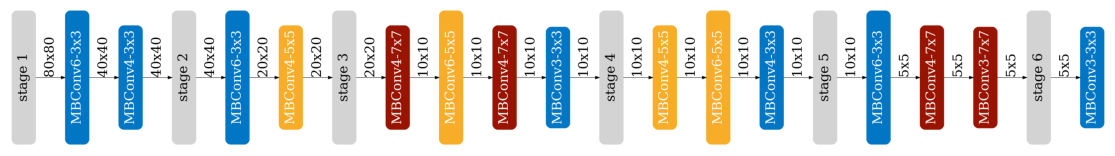

Evolutionary search with constraint: MACs <= 100M


Validate: 100%|██████████| 32/32 [00:02<00:00, 14.75it/s, loss=0.197, top1=93.1]


Accuracy of the selected subnet: 93.07692310721347


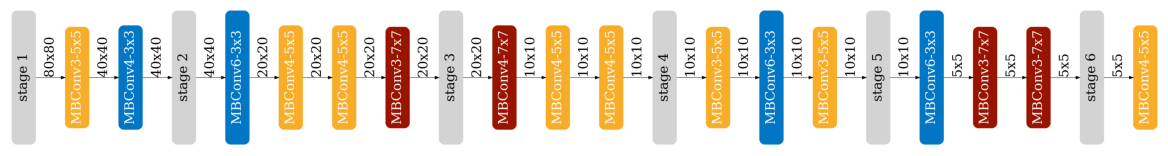

Evolutionary search with constraint: Peak memory <= 256KB


Validate: 100%|██████████| 32/32 [00:01<00:00, 16.21it/s, loss=0.206, top1=92.6]


Accuracy of the selected subnet: 92.6302729301358


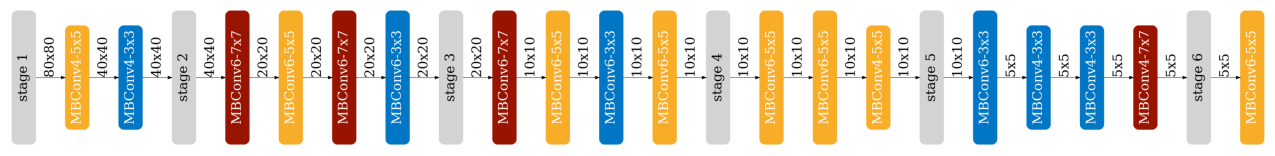

Evolutionary search with constraint: Peak memory <= 512KB


Validate: 100%|██████████| 32/32 [00:02<00:00, 13.49it/s, loss=0.196, top1=93]  


Accuracy of the selected subnet: 93.00248141986856


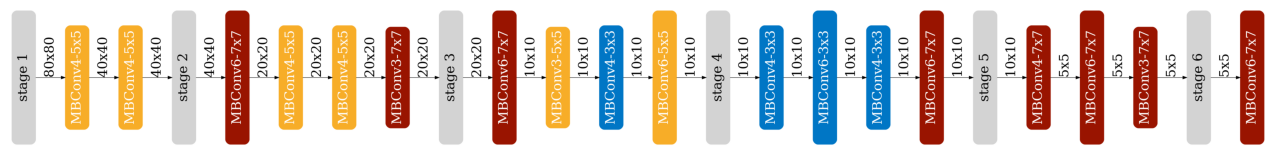

In [ ]:
# hyper-parameters
evo_params = {
    'arch_mutate_prob': 0.3,        # probability of architecture mutation
    'resolution_mutate_prob': 0.5,  # probability of resolution mutation
    'population_size': 50,          # size of the population
    'max_time_budget': 20,
    'parent_ratio': 0.25,
    'mutation_ratio': 0.3,
}

# load the predictor
acc_predictor = AccuracyPredictor(
    arch_encoder,
    hidden_size=400,
    n_layers=3,
    ckpt_path=acc_pred_ckpt_path,
    device=device,
)

# define the agent
nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

# MACs-constrained search
subnets_rs_macs = {}
for millionMACs in [50, 100]:
    search_constraint = dict(millionMACs=millionMACs)
    print(f"Evolutionary search with constraint: MACs <= {millionMACs}M")
    subnets_rs_macs[millionMACs] = search_and_measure_accs(nas_agent, search_constraint)

# memory-constrained search
subnets_rs_memory = {}
for KBPeakMemory in [256, 512]:
    search_constraint = dict(KBPeakMemory=KBPeakMemory)
    print(f"Evolutionary search with constraint: Peak memory <= {KBPeakMemory}KB")
    subnets_rs_memory[KBPeakMemory] = search_and_measure_accs(nas_agent, search_constraint)

#### Question 9

In real-world applications, we may have multiple efficiency constraints like [TensorFlow Lite Micro](https://blog.tensorflow.org/2019/10/visual-wake-words-with-tensorflow-lite_30.html).

Use evolutionary search to find models that satisfy the following constraints:
- 250KB, 60M MACs (acc >= 92.5% to get the full credit)
- 200KB, 30M MACs (acc >= 90% to get the full credit)

**Hint**

You do not have to use the same `evo_params` for these two tasks.

Evolution search with constraint: MACs <= 60M, peak memory <= 250KB


Validate: 100%|██████████| 32/32 [00:01<00:00, 23.01it/s, loss=0.313, top1=86.8]


Accuracy of the selected subnet: 86.79900746310024


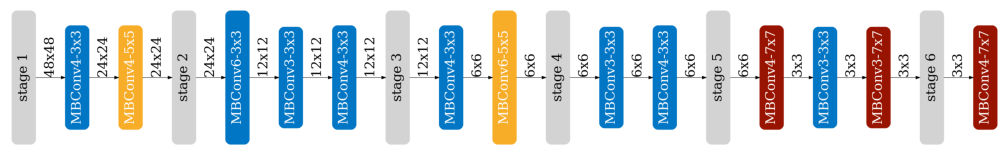

(86.79900746310024,
 MCUNets(
   (first_conv): ConvLayer(
     (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (act): ReLU6(inplace=True)
   )
   (blocks): ModuleList(
     (0): MobileInvertedResidualBlock(
       (mobile_inverted_conv): MBInvertedConvLayer(
         (point_linear): Sequential(
           (conv): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
         )
       )
     )
     (1): MobileInvertedResidualBlock(
       (mobile_inverted_conv): MBInvertedConvLayer(
         (inverted_bottleneck): Sequential(
           (conv): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
           (act): ReLU6(inplace=True)
         )
       

In [44]:
evo_params_rs1 = {
    'arch_mutate_prob': 0.3,
    'resolution_mutate_prob': 0.2,
    'population_size': 20,
    'max_time_budget': 10,  
    'parent_ratio': 0.4,
    'mutation_ratio': 0.3
}
nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params_rs1)

millionMACs, KBPeakMemory = 60, 250
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_accs(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))

In [ ]:
evo_params_rs2 = {
    'arch_mutate_prob': 0.1,
    'resolution_mutate_prob': 0.5,
    'population_size': 50,
    'max_time_budget': 30,
    'parent_ratio': 0.25,
    'mutation_ratio': 0.5,
}
nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params_rs2)

millionMACs, KBPeakMemory = 30, 200
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_accs(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))

#### Experimental Results about Q8, Q9

하이퍼 파라미터에 따른 trade-off 를 정리해보면 다음과 같습니다.

1. ```population_size``` & ```max_time_budget``` 大

    pro: 더 넓은 design space에서 충분히 수렴할 시간을 가짐 \
    con: 총 탐색 시간 증가

2. ```parent_ratio``` 大

    pro: 기존 세대의 성능 좋은 모델을 더 많이 유지하기 때문에 빠른 수렴 속도를 가짐 \
    con: 탐색하는 subnet의 다양성이 줄어들기 때문에 local minimum에 빠질 가능성이 올라감

3. ```arch_mutate_prob``` & ```mutation_ratio``` 大

    pro: 기존의 구조를 많이 변경하여 최적해 도달 가능성을 높임 \
    con: 이전에(pretrained 또는 이전 세대에서) 학습한 정보를 잃어버릴 가능성이 올라감

4. ```resolution_mutate_prob``` 大
    
    pro: 다양한 해상도에 적응 가능 \
    con: 잘못된 해상도(ex. 범위를 벗어난 해상도)로 인해 일부 subnet이 버려짐

따라서, task에서 요구하는 제약 조건(constraint)이 어려울수록 다음과 같은 hyper-parameter 선택이 효과적이라고 생각합니다.

1. ```population_size```  & ```max_time_budget``` 大

    constraint가 어렵다는 것은 뽑을 수 있는 subnet의 개수가 절대적으로 부족할 것이라 판단\
    population_size와 max_time_budget을 높여 최대한 넓은 design space 및 수렴을 위한 충분한 시간 확보

2. ```parent_ratio``` 小

    한정적인 design space를 보완하기 위해서는 subnet의 다양성 필요

3. ```arch_mutate_prob``` & ```mutation_ratio``` 大

    위와 동일하게 한정적인 design space를 보완하기 위해서는 mutation을 통해 다양한 subnet을 학습하는 것이 효과적이라고 판단

4. ```resolution_mutate_prob``` 小

    작은 subnet의 경우 표현할 수 있는 해상도가 매우 제한적일 것으로 판단 \
    불필요한 해상도에 대한 탐색을 막기 위해 확률 감소

#### Question 10

Is it possible to find a subnet with the following efficiency constraints in the current design space?
- A: The activation size of the subnet is **at most 256KB** and the MACs of the subnet is **at most 15M**.
- B: The activation size of the subnet is **at most 64 KB**.

In [19]:
efficiency_predictor = AnalyticalEfficiencyPredictor(ofa_network)
img_size = 96

# smallest subnet
smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=img_size)
eff_smallest = efficiency_predictor.get_efficiency(smallest_cfg)

print("Efficiency stats:", eff_smallest)

Efficiency stats: {'millionMACs': 8.302128, 'KBPeakMemory': 72.0}


**Answer**

- A: 현재 design space에 포함되므로 가능
- B: peak memory가 최소 configuration 보다 작아 현재 design space를 벗어났으므로 불가능